In [1]:
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pickle
import csv

class HelpFunc:
    @staticmethod
    def UnitQamConstellation(Bi):
        EvenSquareRoot = math.ceil(math.sqrt(2 ** Bi) / 2) * 2
        PamM = EvenSquareRoot
        PamConstellation = np.arange(-(PamM - 1), PamM, 2).astype(np.int32)
        PamConstellation = np.reshape(PamConstellation, (1, -1))
        SquareMatrix = np.matmul(np.ones((PamM, 1)), PamConstellation)
        C = SquareMatrix + 1j * (SquareMatrix.T)
        C_tmp = np.zeros(C.shape[0] * C.shape[1]).astype('complex128')
        for i in range(C.shape[1]):
            for j in range(C.shape[0]):
                C_tmp[i * C.shape[0] + j] = C[j][i]
        C = C_tmp
        return C / math.sqrt(np.mean(abs(C) ** 2))

    @staticmethod
    def ComputeChannelCorrMatrix(IsiMagnitude):
        N = len(IsiMagnitude)
        r_f_bold = np.fft.fft(IsiMagnitude)
        r_f_bold_prime = r_f_bold[1:][::-1]
        r_f_bold_conj = np.conjugate(r_f_bold)
        r_f_bold_ext = np.append(r_f_bold_prime, r_f_bold_conj)
        R_f = np.zeros((N, N)).astype('complex128')
        for k in range(0, N):
            R_f[N - k - 1, :] = r_f_bold_ext[k: N + k]
        return R_f

    @staticmethod
    def trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP, x_CP):
        if DelayFlag:
            Delay_LUT = np.zeros(((Max_Delay + 1 - Min_Delay) ** 4, 4)).astype('int32')  # Note: Fixed to **4 for full combos, but may be slow
            count = 0
            temp = np.zeros(Delay_LUT.shape[0])
            for ii in range(Min_Delay, Max_Delay + 1):
                for jj in range(Min_Delay, Max_Delay + 1):
                    for kk in range(Min_Delay, Max_Delay + 1):
                        for ll in range(Min_Delay, Max_Delay + 1):
                            Delay_LUT[count, :] = np.array([ii, jj, kk, ll])
                            if (abs(ii - jj) > 2 or abs(kk - ll) > 2 or abs(ii - kk) > 2 or
                                abs(ii - ll) > 2 or abs(jj - kk) > 2 or abs(jj - ll) > 2):
                                temp[count] = 1
                            count += 1
            Delay_LUT = np.delete(Delay_LUT, np.where(temp > 0)[0], axis=0)
        else:
            Delay_LUT = np.zeros((Max_Delay - Min_Delay + 1, 4)).astype('int32')
            for jjjj in range(Min_Delay, Max_Delay + 1):
                Delay_LUT[jjjj - Min_Delay, :] = jjjj * np.ones(4)

        Delay_Max = np.amax(Delay_LUT, axis=1)
        Delay_Min = np.amin(Delay_LUT, axis=1)
        NMSE_ESN_Training = np.zeros(Delay_LUT.shape[0])
        for jjj in range(Delay_LUT.shape[0]):
            Curr_Delay = Delay_LUT[jjj, :]
            ESN_input = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_output = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[jjj]))
            ESN_output[Curr_Delay[0]: Curr_Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
            ESN_output[Curr_Delay[1]: Curr_Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
            ESN_output[Curr_Delay[2]: Curr_Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
            ESN_output[Curr_Delay[3]: Curr_Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
            nForgetPoints = Delay_Min[jjj] + CyclicPrefixLen
            esn.fit(ESN_input, ESN_output, nForgetPoints)
            x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN_0 = x_hat_ESN_temp[Curr_Delay[0] - Delay_Min[jjj]: Curr_Delay[0] - Delay_Min[jjj] + N + 1, 0] + 1j * x_hat_ESN_temp[Curr_Delay[1] - Delay_Min[jjj]: Curr_Delay[1] - Delay_Min[jjj] + N + 1, 1]
            x_hat_ESN_1 = x_hat_ESN_temp[Curr_Delay[2] - Delay_Min[jjj]: Curr_Delay[2] - Delay_Min[jjj] + N + 1, 2] + 1j * x_hat_ESN_temp[Curr_Delay[3] - Delay_Min[jjj]: Curr_Delay[3] - Delay_Min[jjj] + N + 1, 3]
            x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
            x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
            x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
            x = x_CP[IsiDuration - 1:, :]
            NMSE_ESN_Training[jjj] = (
                np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
                np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
            )
        Delay_Idx = np.argmin(NMSE_ESN_Training)
        NMSE_ESN = np.min(NMSE_ESN_Training)
        Delay = Delay_LUT[Delay_Idx, :]
        ESN_input = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_output = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_output[Delay[0]: Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
        ESN_output[Delay[1]: Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
        ESN_output[Delay[2]: Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
        ESN_output[Delay[3]: Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
        nForgetPoints = Delay_Min[Delay_Idx] + CyclicPrefixLen
        esn.fit(ESN_input, ESN_output, nForgetPoints)
        Delay_Minn = Delay_Min[Delay_Idx]
        Delay_Maxx = Delay_Max[Delay_Idx]
        return [ESN_input, ESN_output, esn, Delay, Delay_Idx, Delay_Minn, Delay_Maxx, nForgetPoints, NMSE_ESN]

def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

def identity(x):
    return x

class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=200, spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None, teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity, random_state=None, silent=True):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand
        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, nForgetPoints=0, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])
        transient = max(0, nForgetPoints)
        extended_states = np.hstack((states, inputs_scaled))
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        pred_train = self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Data flow check: Print if imports succeeded (no output expected if successful)
print("Imports and helper functions defined successfully.")

Imports and helper functions defined successfully.


In [13]:
# Physical Parameters
W = 2 * 1.024e6  # Bandwidth
f_D = 100  # Doppler Frequency
No = 0.00001  # Noise PSD
IsiDuration = 8  # Multipath components
cFlag = False  # Fixed CIR flag
EbNoDB = np.arange(25, 30 + 1, 5).astype(np.int32)  # SNR range

# MIMO Parameters
N_t = 2  # Transmit antennas
N_r = 2  # Receive antennas

# Design Parameters
N = 64  # Subcarriers
Subcarrier_Spacing = W / N
m = 4  # Data QAM order
m_pilot = 4  # Pilot QAM order
NumOfdmSymbols = 1000  # Symbols to simulate
Ptotal = 10 ** (EbNoDB / 10) * No * N  # Total power

# Power Amplifier
p_smooth = 1
ClipLeveldB = 3

# Secondary Parameters
T_OFDM = N / W  # OFDM symbol duration
T_OFDM_Total = (N + IsiDuration - 1) / W  # Including CP
T_s = 1 / W  # Sampling period
tau_c = 0.5 / f_D  # Channel coherence time
L = math.floor(tau_c / T_OFDM_Total)  # Coherence in symbols
Pi = Ptotal / N  # Power per subcarrier
NumBitsPerSymbol = m * N
Const = HelpFunc.UnitQamConstellation(m)  # Data constellation
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)  # Pilot constellation
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# ISI Channel Profile
temp = CyclicPrefixLen / 9
IsiMagnitude = np.exp(-(np.arange(CyclicPrefixLen + 1)) / temp)
IsiMagnitude = IsiMagnitude / sum(IsiMagnitude)

# ESN Parameters
var_x = np.float_power(10, (EbNoDB / 10)) * No * N
nInputUnits = N_t * 2
nOutputUnits = N_t * 2
nInternalUnits = 5000
inputScaler = 0.005
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.0000005 * np.ones(N_t * 2)
spectralRadius = 0.9
teacherShift = np.zeros(N_t * 2)
feedbackScaling = feedbackScaler * np.ones(N_t * 2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration / 2) + 2
DelayFlag = 0

# Initialize Arrays
ESN_train_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_train_teacher = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_output = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]
MMSEScaler = No / Pi
R_h = np.zeros((IsiDuration, IsiDuration))
for ii in range(IsiDuration):
    R_h[ii, ii] = IsiMagnitude[ii]

# Data Flow Check
print("=== Parameter Initialization ===")
print(f"EbNoDB: {EbNoDB}")
print(f"Ptotal shape: {Ptotal.shape}, values: {Ptotal}")
print(f"Subcarrier Spacing: {Subcarrier_Spacing:.2e} Hz")
print(f"Coherence Length (L): {L} symbols")
print(f"ISI Magnitude shape: {IsiMagnitude.shape}, first few values: {IsiMagnitude[:3]}")
print(f"Data Constellation shape: {Const.shape}, first few points: {Const[:3]}")
print(f"BER Arrays shape: {BER_ESN.shape}")
print(f"Channel Matrix (R_h) shape: {R_h.shape}, diagonal: {np.diag(R_h)}")

=== Parameter Initialization ===
EbNoDB: [25 30]
Ptotal shape: (2,), values: [0.20238577 0.64      ]
Subcarrier Spacing: 3.20e+04 Hz
Coherence Length (L): 144 symbols
ISI Magnitude shape: (8,), first few values: [0.72357164 0.20003358 0.05529989]
Data Constellation shape: (16,), first few points: [-0.9486833-0.9486833j  -0.9486833-0.31622777j -0.9486833+0.31622777j]
BER Arrays shape: (2,)
Channel Matrix (R_h) shape: (8, 8), diagonal: [7.23571639e-01 2.00033584e-01 5.52998938e-02 1.52878241e-02
 4.22636555e-03 1.16839163e-03 3.23005427e-04 8.92958343e-05]


In [14]:
# Select first SNR
jj = 0
print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")

# SNR-specific parameters
A_Clip = np.sqrt(var_x[jj]) * np.float_power(10, ClipLeveldB / 20)
inputScaling = inputScaler / (var_x[jj] ** 0.5) * np.ones(N_t * 2)
inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
TotalBerNum_ESN = 0
TotalBerNum_LS = 0
TotalBerNum_MMSE = 0
TotalBerNum_Perfect = 0
TotalBerDen = 0
x_ISI = np.zeros(CyclicPrefixLen).astype('complex128')
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N / 2) * np.eye(IsiDuration))

# Process one pilot symbol (kk=1, remainder(kk,L)=1 triggers pilot)
kk = 1
print(f"Processing pilot symbol {kk}")

# Channel Generation
for nnn in range(N_r):
    for mmm in range(N_t):
        c[nnn][mmm] = np.random.normal(size=IsiDuration) / (2 ** 0.5) + 1j * np.random.normal(size=IsiDuration) / (2 ** 0.5)
        c[nnn][mmm] = c[nnn][mmm] * (IsiMagnitude ** 0.5)
        Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - len(c[nnn][mmm]))))

# Pilot Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
        X[ii, iii] = ConstPilot[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Channel and Noise
Y = np.zeros((N, N_r)).astype('complex128')
y_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
noise = np.zeros(y_CP.shape).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        y_CP[:, nnn] = y_CP[:, nnn] + signal.lfilter(c[nnn][mmm], np.array([1]), x_CP[:, mmm])
    noise[:, nnn] = math.sqrt(y_CP.shape[0] * No / 2) * np.matmul(np.random.normal(size=(y_CP.shape[0], 2)), np.array([[1], [1j]])).reshape(-1)
    y_CP[:, nnn] = y_CP[:, nnn] + noise[:, nnn]
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP[IsiDuration - 1:, nnn])

# Orthogonal Pilots for LS
X_LS = X.copy()
X_LS[np.arange(1, len(X_LS), 2), 0] = 0  # Tx1: even subcarriers
X_LS[np.arange(0, len(X_LS), 2), 1] = 0  # Tx2: odd subcarriers
x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X_LS[:, iii])
    x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
Y_LS = np.zeros((N, N_r)).astype('complex128')
y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        y_LS_CP[:, nnn] = y_LS_CP[:, nnn] + signal.lfilter(c[nnn][mmm], np.array([1]), x_LS_CP[:, mmm])
    y_LS_CP[:, nnn] = y_LS_CP[:, nnn] + noise[:, nnn]
    Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
Y_LS = Y_LS / (Pi[jj] ** 0.5)

# LS and MMSE Channel Estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
        c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])
        c_LS = c_LS[:IsiDuration]
        c_MMSE = np.linalg.solve(MMSE_bold_TD, c_LS)
        Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
        if mmm == 0:
            tmpf = interpolate.interp1d(np.append(np.arange(mmm, N, N_t), N - 1), np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1]))
            Ci_LS[nnn][mmm] = tmpf(np.arange(N))
        else:
            tmpf = interpolate.interp1d(np.append(0, np.arange(mmm, N, N_t)), np.append(Ci_LS_Pilots[nnn][mmm][0], Ci_LS_Pilots[nnn][mmm]))
            Ci_LS[nnn][mmm] = tmpf(np.arange(N))

# ESN Training
x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + signal.lfilter(c[nnn][mmm], np.array([1]), x_CP_NLD[:, mmm])
    y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + noise[:, nnn]
esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
          teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
[ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = \
    HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
ESN_train_input[kk - 1][jj] = ESN_input
ESN_train_teacher[kk - 1][jj] = ESN_output
NMSE_ESN_Training[jj] += NMSE_ESN

# Data Flow Check
print("\n=== Pilot Symbol Data Flow ===")
print(f"Channel c[0][0] shape: {c[0][0].shape}, first few taps: {c[0][0][:3]}")
print(f"Frequency response Ci[0][0] shape: {Ci[0][0].shape}, first few values: {Ci[0][0][:3]}")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"LS Estimated Ci_LS[0][0] shape: {Ci_LS[0][0].shape}, first few values: {Ci_LS[0][0][:3]}")
print(f"MMSE Estimated Ci_MMSE[0][0] shape: {Ci_MMSE[0][0].shape}, first few values: {Ci_MMSE[0][0][:3]}")
print(f"ESN Input shape: {ESN_input.shape}, first few values: {ESN_input[:3, :]}")
print(f"ESN Output shape: {ESN_output.shape}, first few values: {ESN_output[:3, :]}")
print(f"ESN NMSE Training: {NMSE_ESN}")
print(f"Optimal Delays: {Delay}, Delay Index: {Delay_Idx}")


=== Processing SNR: EbNoDB = 25 dB ===
Processing pilot symbol 1

=== Pilot Symbol Data Flow ===
Channel c[0][0] shape: (8,), first few taps: [ 0.71630376-0.66068462j -0.11645453+0.14737821j -0.0268987 -0.1190467j ]
Frequency response Ci[0][0] shape: (64,), first few values: [0.6690652 -0.71473618j 0.62818092-0.72255946j 0.58358676-0.71388844j]
Transmitted X shape: (64, 2), first few symbols: [[-0.9486833 -0.9486833j  -0.9486833 -0.31622777j]
 [-0.31622777+0.9486833j  -0.31622777+0.9486833j ]
 [ 0.9486833 +0.31622777j  0.31622777-0.9486833j ]]
Received Y shape: (64, 2), first few symbols: [[-0.0689492 -0.02575343j  0.00666614+0.06605099j]
 [-0.00663512+0.04396599j  0.05044883-0.05304064j]
 [ 0.07278249-0.03306615j  0.01534305+0.00755859j]]
LS Estimated Ci_LS[0][0] shape: (64,), first few values: [0.6381224 -0.71475854j 0.55887658-0.75352624j 0.47963075-0.79229393j]
MMSE Estimated Ci_MMSE[0][0] shape: (64,), first few values: [0.49271974-0.46439431j 0.49398577-0.46214836j 0.49546938-0.

In [15]:
# Process one data symbol (kk=2, after pilot)
kk = 10
print(f"\n=== Processing data symbol {kk} ===")

# Data Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
        X[ii, iii] = Const[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA
x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

# Reception
Y_NLD = np.zeros((N, N_r)).astype('complex128')
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + signal.lfilter(c[nnn][mmm], np.array([1]), x_CP_NLD[:, mmm])
    y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + math.sqrt(y_CP.shape[0] * No / 2) * np.matmul(np.random.normal(size=(y_CP.shape[0], 2)), np.array([[1], [1j]])).reshape(-1)
    Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# ESN Detection
ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
nForgetPoints = Delay_Min + CyclicPrefixLen
x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N + 1, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N + 1, 1]
x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N + 1, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N + 1, 3]
x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
x = x_CP[IsiDuration - 1:, :]
NMSE_ESN_Testing[jj] += (
    np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
    np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
)
X_hat_ESN = np.zeros(X.shape).astype('complex128')
for ii in range(N_t):
    X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
ESN_test_input[kk - 1][jj] = ESN_input
ESN_test_output[kk - 1][jj] = x_hat_ESN

# Classical Detection
H_temp = np.zeros((N_r, N_t)).astype('complex128')
H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
X_hat_Perfect = np.zeros(X.shape).astype('complex128')
X_hat_LS = np.zeros(X.shape).astype('complex128')
X_hat_MMSE = np.zeros(X.shape).astype('complex128')
for ii in range(N):
    Y_temp = np.transpose(Y_NLD[ii, :])
    for nnn in range(N_r):
        for mmm in range(N_t):
            H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
            H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
            H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
    X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
    X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
    X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

# Bit Detection
RxBits_ESN = np.zeros(TxBits.shape)
RxBits_LS = np.zeros(TxBits.shape)
RxBits_MMSE = np.zeros(TxBits.shape)
RxBits_Perfect = np.zeros(TxBits.shape)
for ii in range(N):
    for iii in range(N_t):
        # Perfect
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
        # ESN
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
        # LS
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
        # MMSE
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

# Accumulate BER
TotalBerNum_ESN += np.sum(TxBits != RxBits_ESN)
TotalBerNum_LS += np.sum(TxBits != RxBits_LS)
TotalBerNum_MMSE += np.sum(TxBits != RxBits_MMSE)
TotalBerNum_Perfect += np.sum(TxBits != RxBits_Perfect)
TotalBerDen += NumBitsPerSymbol * N_t  # Corrected to account for bits per symbol per antenna

# Data Flow Check
print("\n=== Data Symbol Data Flow ===")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y_NLD shape: {Y_NLD.shape}, first few symbols: {Y_NLD[:3, :]}")
print(f"ESN Estimated X_hat_ESN shape: {X_hat_ESN.shape}, first few symbols: {X_hat_ESN[:3, :]}")
print(f"Perfect Estimated X_hat_Perfect shape: {X_hat_Perfect.shape}, first few symbols: {X_hat_Perfect[:3, :]}")
print(f"LS Estimated X_hat_LS shape: {X_hat_LS.shape}, first few symbols: {X_hat_LS[:3, :]}")
print(f"MMSE Estimated X_hat_MMSE shape: {X_hat_MMSE.shape}, first few symbols: {X_hat_MMSE[:3, :]}")
print(f"ESN NMSE Testing: {NMSE_ESN_Testing[jj]}")
print(f"Bit Errors (this symbol) - ESN: {np.sum(TxBits != RxBits_ESN)}, LS: {np.sum(TxBits != RxBits_LS)}, MMSE: {np.sum(TxBits != RxBits_MMSE)}, Perfect: {np.sum(TxBits != RxBits_Perfect)}")
print(f"Total Bits: {TotalBerDen}")


=== Processing data symbol 10 ===

=== Data Symbol Data Flow ===
Transmitted X shape: (64, 2), first few symbols: [[ 0.31622777+0.31622777j -0.9486833 +0.31622777j]
 [-0.9486833 -0.31622777j -0.31622777-0.31622777j]
 [-0.31622777+0.9486833j  -0.31622777+0.9486833j ]]
Received Y_NLD shape: (64, 2), first few symbols: [[-0.00415699-0.01848483j  0.04250648-0.05394245j]
 [-0.02421745+0.01068051j  0.01357531+0.05559336j]
 [-0.00423061+0.03441967j  0.0324945 -0.05628252j]]
ESN Estimated X_hat_ESN shape: (64, 2), first few symbols: [[ 0.06712404-0.00435j    -1.18160008+0.22893741j]
 [-0.82909827-0.21091436j -0.09162132-0.18868855j]
 [-0.32676087+1.222481j   -0.71457285+1.09331415j]]
Perfect Estimated X_hat_Perfect shape: (64, 2), first few symbols: [[ 0.11570913+0.19047068j -0.79811338+0.37763091j]
 [-0.65822995-0.2307882j  -0.17412755-0.32128644j]
 [-0.19875458+0.78801594j -0.24637437+0.85139433j]]
LS Estimated X_hat_LS shape: (64, 2), first few symbols: [[ 0.13622848+0.22519277j -0.7311532


=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 49, LS: 25, MMSE: 45, Perfect: 21
ESN NMSE (this symbol): 0.22592591947578847

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 42, LS: 31, MMSE: 47, Perfect: 25
ESN NMSE (this symbol): 0.19803121176278515

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 56, LS: 38, MMSE: 46, Perfect: 27
ESN NMSE (this symbol): 0.24879261222835325

=== Processing data symbol 6 ===
Bit Errors (this symbol) - ESN: 63, LS: 35, MMSE: 44, Perfect: 25
ESN NMSE (this symbol): 0.26789707305479343

=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===
BER_ESN: 0.105078, BER_LS: 0.058203, BER_MMSE: 0.090625, BER_Perfect: 0.044141
NMSE_ESN_Training: 0.002757
NMSE_ESN_Testing: 0.235388
Total Bits Processed: 2560


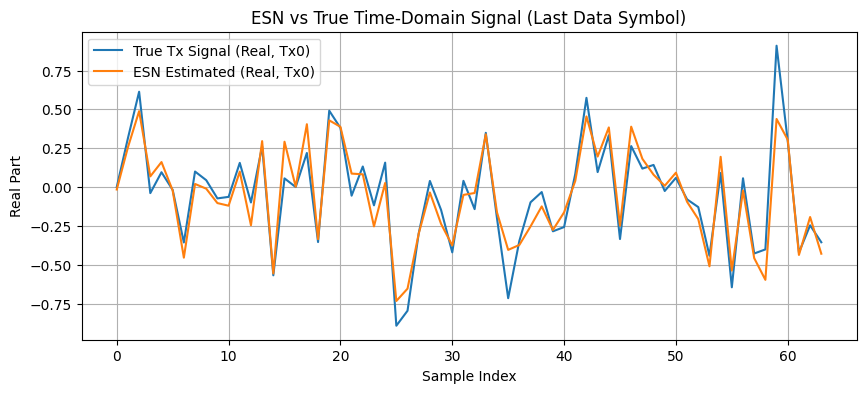

In [16]:
# Initialize NMSE count from previous data symbol
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 6, for example)
for kk in range(3, 7):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
            X[ii, iii] = Const[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Reception
    Y_NLD = np.zeros((N, N_r)).astype('complex128')
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + signal.lfilter(c[nnn][mmm], np.array([1]), x_CP_NLD[:, mmm])
        y_CP_NLD[:, nnn] = y_CP_NLD[:, nnn] + math.sqrt(y_CP.shape[0] * No / 2) * np.matmul(np.random.normal(size=(y_CP.shape[0], 2)), np.array([[1], [1j]])).reshape(-1)
        Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = Delay_Min + CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N + 1, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N + 1, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N + 1, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N + 1, 3]
    x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
    x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
    x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y_NLD[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # Bit Detection
    RxBits_ESN = np.zeros(TxBits.shape)
    RxBits_LS = np.zeros(TxBits.shape)
    RxBits_MMSE = np.zeros(TxBits.shape)
    RxBits_Perfect = np.zeros(TxBits.shape)
    for ii in range(N):
        for iii in range(N_t):
            # Perfect
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
            # ESN
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
            # LS
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
            # MMSE
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

    # Accumulate BER
    bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
    bit_errors_LS = np.sum(TxBits != RxBits_LS)
    bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
    bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += NumBitsPerSymbol * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 5 data symbols total so far: kk=2,3,4,5,6)
num_symbols_so_far = 6  # pilot at 1, data at 2-6
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print("\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")

# Optional Plot: Compare ESN prediction vs true for last symbol, Tx0 real part
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0].real, label='True Tx Signal (Real, Tx0)')
plt.plot(x_hat_ESN[:, 0].real, label='ESN Estimated (Real, Tx0)')
plt.legend()
plt.title('ESN vs True Time-Domain Signal (Last Data Symbol)')
plt.xlabel('Sample Index')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()